brisanje null vrednosti iz kolone koju predvidjamo, a popunjavanje srednjom vrednoscu u kolonu za visok nivo samopouzdanja
pretvaranje objekata(kolone tipa object) u categorical radi lakseg rukovanja

In [19]:
import pandas as pd

# Load the dataset
data = pd.read_csv('HealthBMI.csv')

# Drop rows where 'Confidence_limit_Low' is missing
data = data.dropna(subset=['Confidence_limit_Low'])

# Fill missing values in 'Data_value' and 'Confidence_limit_High' with the mean
for column in ['Data_value', 'Confidence_limit_High']:
    data[column] = data[column].fillna(data[column].mean())

# Convert categorical columns to numeric using one-hot encoding
categorical_columns = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=categorical_columns)


sada cu da vidim koje kolone najvise uticu na low confidence pomocu korelacije  (funkcije necu crtati matricu)

In [20]:
correlations = data.corr()['Confidence_limit_Low'].sort_values()
print(correlations)

ResponseID_RESP042                     -0.822334
Response_Underweight (BMI 12.0-18.4)   -0.702138
Response_Underweight (bmi 12.0-18.4)   -0.382661
Break_Out_Multiracial, non-Hispanic    -0.049744
BreakoutID_RACE07                      -0.040747
                                          ...   
Data_value_unit_%                            NaN
Data_value_type_Crude Prevalence             NaN
DataSource_BRFSS                             NaN
ClassId_CLASS14                              NaN
QuestionID__BMI5CAT                          NaN
Name: Confidence_limit_Low, Length: 321, dtype: float64


In [ ]:
kao sto  sam mogla pretpostaviti ofc weight i to specificno under sad cu da izbacim opsti response da vidimj bolje
da l under over ili mid uticu najvise (psl sam i break nbt)

In [24]:
#columns=['ResponseID_RESP042','BreakoutID_RACE07']

columns_to_drop = ['ResponseID_RESP042', 'BreakoutID_RACE07']
data = data.drop(columns=[col for col in columns_to_drop if col in data.columns])

correlations = data.corr()['Confidence_limit_Low'].sort_values()
print(correlations)

Response_Underweight (BMI 12.0-18.4)   -0.702138
Response_Underweight (bmi 12.0-18.4)   -0.382661
Break_Out_Multiracial, non-Hispanic    -0.049744
BreakOutCategoryID_CAT4                -0.039487
Break_Out_Category_Race/Ethnicity      -0.039487
                                          ...   
Data_value_unit_%                            NaN
Data_value_type_Crude Prevalence             NaN
DataSource_BRFSS                             NaN
ClassId_CLASS14                              NaN
QuestionID__BMI5CAT                          NaN
Name: Confidence_limit_Low, Length: 319, dtype: float64


okej definitivno najvise utice  underweight, ajmo neuronska

In [26]:
import tensorflow as tf

# Define the neural network architecture with an explicit Input layer
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(data.shape[1]-1,)),  # Explicitly define the input shape
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])


ajmo trening test

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define features and target variable
X = data.drop('Confidence_limit_Low', axis=1)
y = data['Confidence_limit_Low']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


Epoch 1/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 87.5806 - mean_absolute_error: 5.4587 - val_loss: 2.4961 - val_mean_absolute_error: 1.0648
Epoch 2/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.9543 - mean_absolute_error: 0.9667 - val_loss: 1.6226 - val_mean_absolute_error: 0.8844
Epoch 3/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3329 - mean_absolute_error: 0.8172 - val_loss: 1.2850 - val_mean_absolute_error: 0.7739
Epoch 4/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1257 - mean_absolute_error: 0.7536 - val_loss: 1.3077 - val_mean_absolute_error: 0.7877
Epoch 5/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.9911 - mean_absolute_error: 0.7169 - val_loss: 1.2182 - val_mean_absolute_error: 0.7838
Epoch 6/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8967 - mean_absolute_error: 0.6800 - val_loss: 1.0938 - val_mean_absolute_error: 0.6969
Epoch 7/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7486 - mean_absolute_er

ovo je dobar output dobra je neuronska MAE je malo sto znaci da precizno tj da su testni rez dobri
sad cu da vizualizujem ovo sto sam dobila i iskomentarisem i tjt od mene prvo cu validation i trening loss da vidim koliko se poklapa

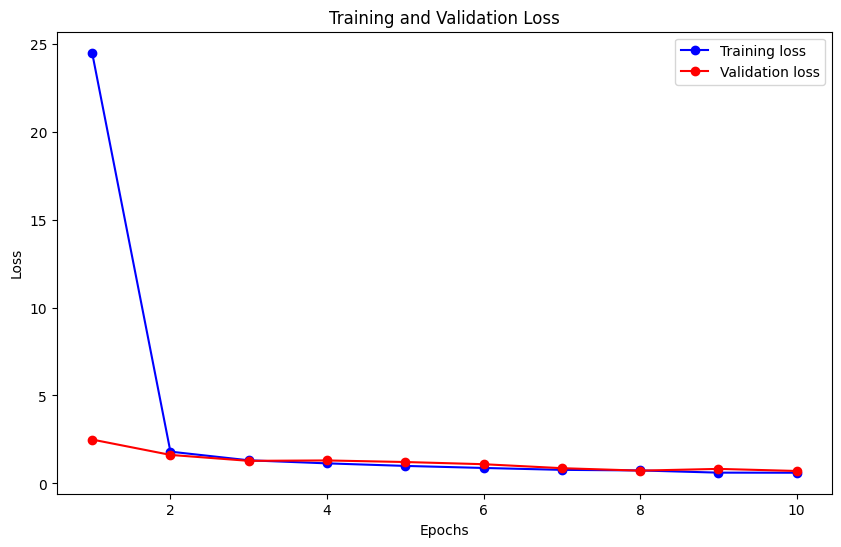

In [28]:
import matplotlib.pyplot as plt

# Assuming 'history' is the output from your model.fit()
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'bo-', label='Training loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


okej generalno je dobro ovo na pocetku pp da su neki izuzeci i spec slucajevi 
sad cu MAE

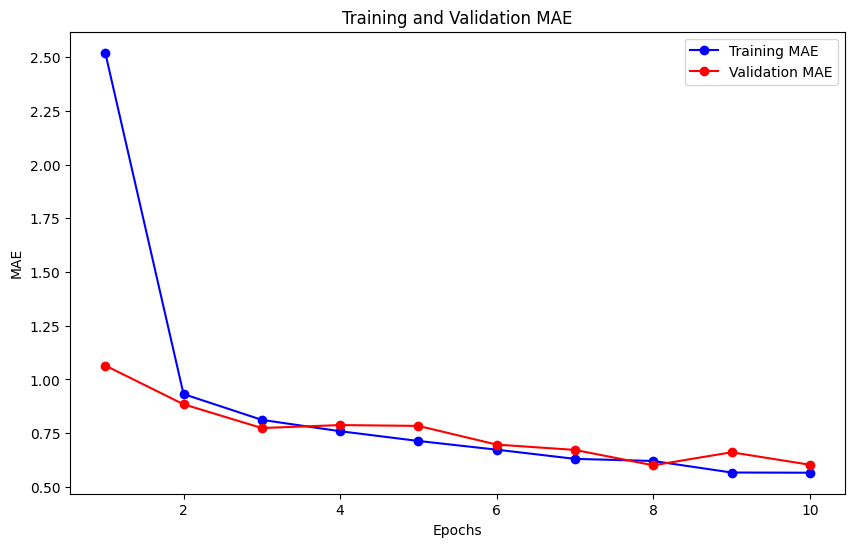

In [29]:
training_mae = history.history['mean_absolute_error']
validation_mae = history.history['val_mean_absolute_error']

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_mae, 'bo-', label='Training MAE')
plt.plot(epochs, validation_mae, 'ro-', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


sto je opet vrlo slicno znaci top, cini se da nema overfittinga jer 

1286/1286 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step


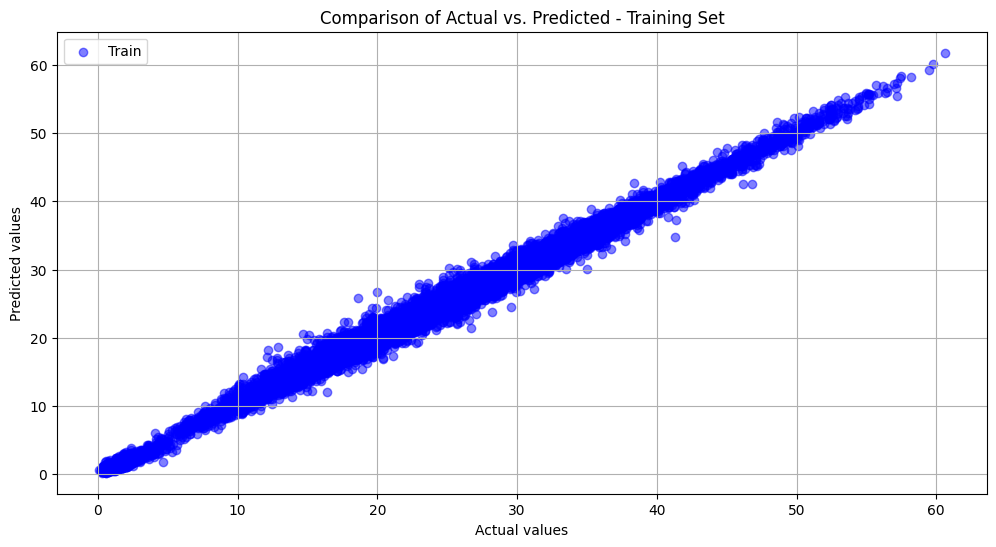

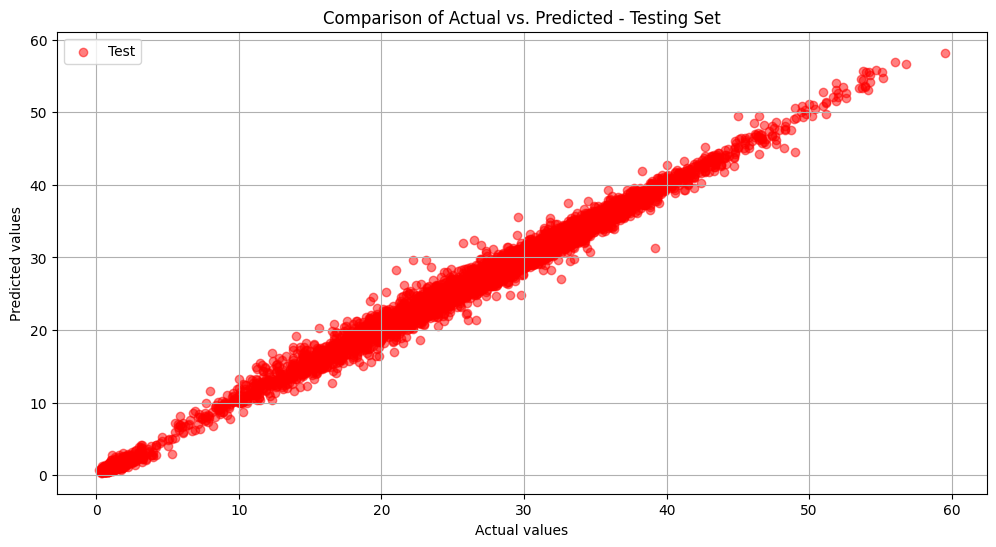

In [31]:
import matplotlib.pyplot as plt

# Assuming X_train_scaled and X_test_scaled are your feature sets
train_predictions = model.predict(X_train_scaled)
test_predictions = model.predict(X_test_scaled)

# Plot for Training Data
plt.figure(figsize=(12, 6))
plt.scatter(y_train, train_predictions, alpha=0.5, color='blue', label='Train')
plt.title('Comparison of Actual vs. Predicted - Training Set')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Testing Data
plt.figure(figsize=(12, 6))
plt.scatter(y_test, test_predictions, alpha=0.5, color='red', label='Test')
plt.title('Comparison of Actual vs. Predicted - Testing Set')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.legend()
plt.grid(True)
plt.show()


tjt dosta

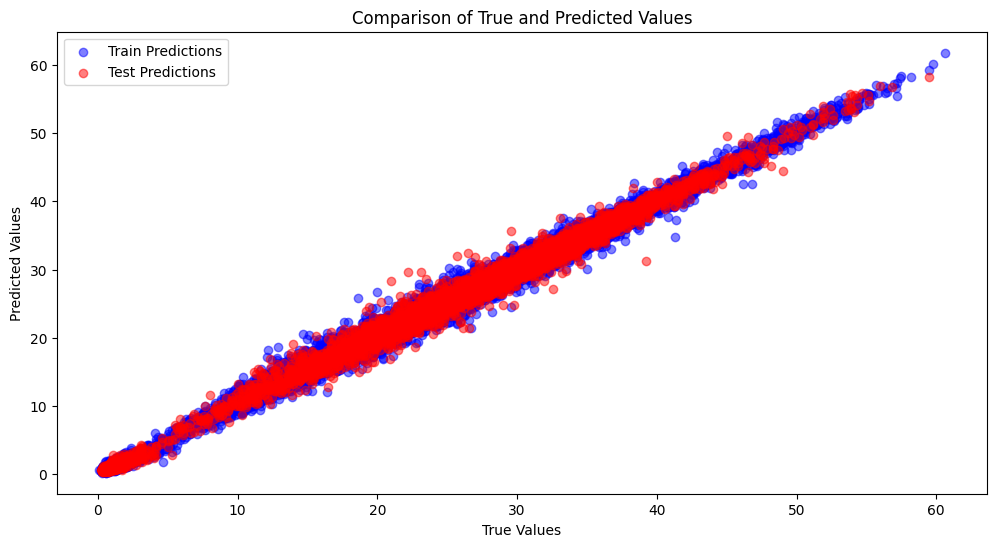

In [32]:
import matplotlib.pyplot as plt

# Scatter plot for training data
plt.figure(figsize=(12, 6))
plt.scatter(y_train, train_predictions, alpha=0.5, color='blue', label='Train Predictions')
plt.scatter(y_test, test_predictions, alpha=0.5, color='red', label='Test Predictions')
plt.title('Comparison of True and Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()


evo mzd bolje na jednom grafu